In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dataCollection import *

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
OC = 'NGC_752'

In [3]:
#step0: match apogee data with gaia data
#apogee_Teff = matchApogeeGaia('k2')

#step 1: get members in gaia IDs and write a simbad input file
gaia_IDs, member_df = genSimbad(OC, "{}/{}_simbad_input.txt".format(OC,OC))

#step 2: astroquery for gaia Gband mags, luminosities and distances, then tm_IDs
gaia_df = GAIA_query(gaia_IDs)
gaia_df = GAIA_query_tm(gaia_df, gaia_IDs)

#step 3: merging apogee_gaia df with gaia_df
step3_df = matchApogeeToData(gaia_df)

There is 253 stars in the membership paper.
Simbad input txt file saved as "NGC_752/NGC_752_simbad_input.txt".
Launching GAIA query...


Obtained 253 out of 253 stars in the cluster.
Launching GAIA query...


252 out of 253 stars in the cluster have cross match 2MASS IDs.
Matching APOGEE Teffs to queried GAIA stars
Found 0 matching stars with APOGEE Teff data.


In [4]:
#step 4: read simbad output file and combine it to step3_df
step4_df = readSimbad(f'{OC}/{OC}_simbad_output.txt',step3_df)

#step 5: matching back in ra, dec and membership prob from membership paper, and apply membership cut for total membership>99%
step5_df = membershipCut(step4_df, member_df)

#step 6: Teff selection: 1.apogee, 2.singulars, 3.take away problematics, 
# 4.apply most widespread source of Teff until all multiples have Teff, 5.manual picking of problematics
assigned_df, problematic_df, final_ranks = assignTeff(step5_df)
final_ranks

Reading SIMBAD output and merging it to GAIA+APOGEE data...
found 253 matching IDs
41 stars have Teff data
Found Teff for 41 stars between SIMBAD and APOGEE.
Matching in membership data and applying membership cut...
39/41 stars are taken as cluster members
Using APOGEE Teff for 0 stars.
There are 30 stars without APOGEE data and have Teff provided by only one paper.
Picking Teff automatically for 9 stars, 0 stars require manual picking.


C:\Users\User\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
C:\Users\User\Documents\UoB physics stuff\year 4\FYP\Simbad\dataCollection.py:310: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Teff'][i] = paper[0]
C:\Users\User\Documents\UoB physics stuff\year 4\FYP\Simbad\dataCollection.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ref'][i] = paper[2]
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopy

,ref,count
0,2013AJ....146..143M,27.0
1,2015MNRAS.446.3562B,10.0
2,2004A&A...426..809S,2.0


In [5]:
#manual assigning of problematic Teffs
problematic_df = replaceManual(problematic_df, final_ranks)
step6_df = pd.concat([assigned_df,problematic_df])
step6_df.sort_index(inplace=True)

In [6]:
#listing all papers to google
countUniqueRefs(step6_df, column='ref')

,ref,count
0,2013AJ....146..143M,27.0
1,2015MNRAS.446.3562B,10.0
2,2004A&A...426..809S,2.0


In [7]:
#Matching Teff errors from papers:
resulting_df = matchTeff_err(step6_df, '2013AJ....146..143M', OC+'/2013AJ....146..143M_Teff.txt', None,None,10,11)
#this paper only contribute RGB stars, putting in 100K Teff error as proxy
resulting_df = fixedTeff_err(resulting_df, '2015MNRAS.446.3562B', 100)
step7_df = fixedTeff_err(resulting_df, '2004A&A...426..809S', 150)

C:\Users\User\Documents\UoB physics stuff\year 4\FYP\Simbad\dataCollection.py:497: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Teff_err'][i]=Teff_err[j]
C:\Users\User\Documents\UoB physics stuff\year 4\FYP\Simbad\dataCollection.py:521: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Teff_err'][i]=Teff_err


In [8]:
ra_dec_conv('01 57 41.0','+37 47 06')

29.420833333333334 37.785


In [9]:
dist = step7_df['distance']
dist = dist[np.logical_not(np.isnan(dist))]
dist_err = step7_df['distance_err']
dist_err = dist_err[np.logical_not(np.isnan(dist_err))]
mean_dist = np.sum(dist*dist_err**(-2))/np.sum(dist_err**(-2))
mean_dist_err = np.sqrt(1/np.sum(dist_err**(-2)))
print(mean_dist, mean_dist_err)
#mean_dist_err=0
luminosity, luminosity_err = lum_calc(OC, step7_df['g_mag'], step7_df['g_mag_err'], mean_dist, mean_dist_err, list(step7_df['Teff']), list(step7_df['Teff_err']))
step8_df = step7_df.copy()
step8_df['cal_lum'] = luminosity
step8_df['cal_lum_err'] = luminosity_err
step8_df.dropna(subset=['cal_lum'],inplace=True)

440.6660452073633 1.2226744088437396


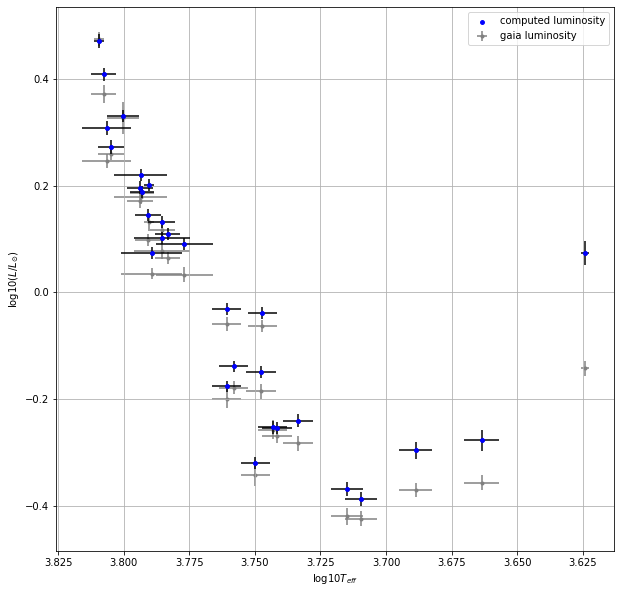

In [10]:
#apply cut that removes RGB stars
step8_df['value'] = 10*np.log10(step8_df['Teff'])-np.log10(step8_df['cal_lum'])-35.5
cut_df = step8_df[step8_df['value']>0].copy()

#plotting cluster to count number of blue stragglers, and other stars to remove
plotCluster(cut_df, plot_gaia=True)

23


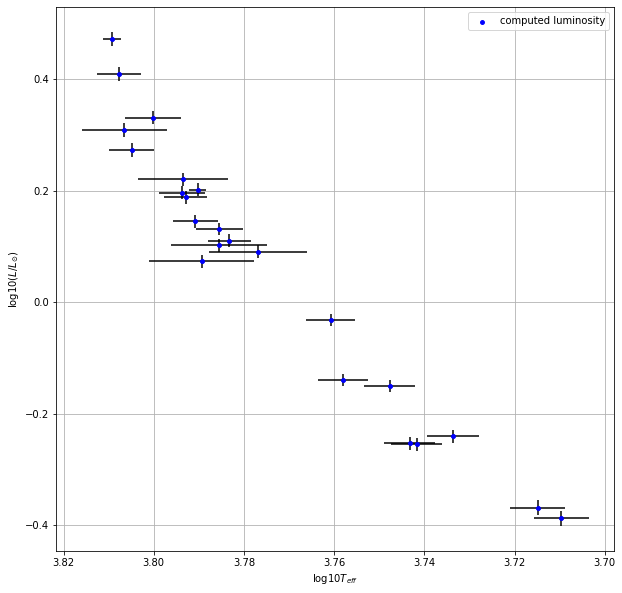

In [15]:
#removing blue stragglers
#no blue stragglers
step9_df = cut_df.copy()

#removing other weird stars
step9_df = removeStars(step9_df, 3.625, 0.2,1)
step9_df = removeStars(step9_df, 3.66, -0.2,1)
step9_df = removeStars(step9_df, 3.68, -0.2,1)
step9_df = removeStars(step9_df, 3.75, -0.3,1)
step9_df = removeStars(step9_df, 3.76, -0.18,1)
step9_df = removeStars(step9_df, 3.74, 0,1)

print(len(step9_df.index))
plotCluster(step9_df, plot_gaia=False, plot_train=False, grid_path='grid2_early.csv')

In [16]:
#save data to csv
step9_df.to_csv(f'{OC}/{OC}_final.csv',index=False)

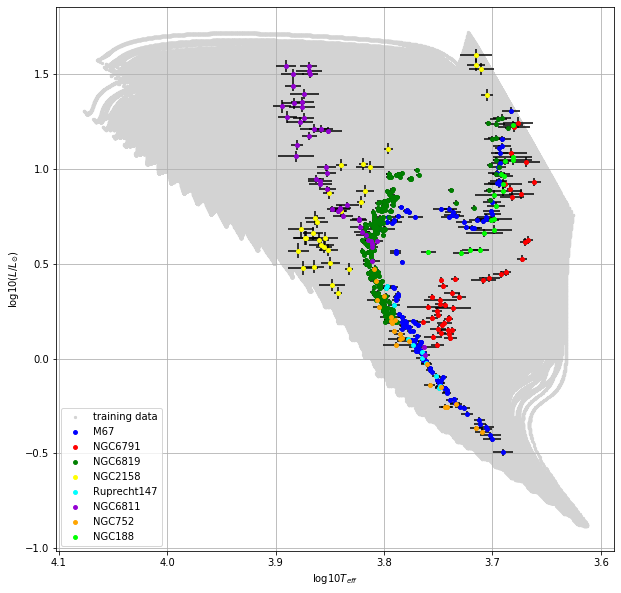

In [22]:
def prepPlot(df, colour, label):
    log_cal_lum_err = df['cal_lum_err']/(df['cal_lum']*np.log(10))
    log_Teff_err = df['Teff_err']/(df['Teff']*np.log(10))
    ax.errorbar(np.log10(df['Teff']), np.log10(df['cal_lum']), xerr=log_Teff_err, yerr=log_cal_lum_err, fmt='.', zorder=2, c='black')
    ax.scatter(np.log10(df['Teff']), np.log10(df['cal_lum']), s=15, zorder=3, c=colour, label=label)

M67_df = pd.read_csv('NGC_2682/NGC_2682_final.csv')
NGC6791_df = pd.read_csv('NGC_6791/NGC_6791_final.csv')
NGC6819_df = pd.read_csv('NGC_6819/NGC_6819_final.csv')
NGC2158_df = pd.read_csv('NGC_2158/NGC_2158_final.csv')
Ruprecht147_df = pd.read_csv('Ruprecht_147/Ruprecht_147_final.csv')
NGC6811_df = pd.read_csv('NGC_6811/NGC_6811_final.csv')
NGC752_df = pd.read_csv('NGC_752/NGC_752_final.csv')
NGC188_df = pd.read_csv('NGC_188/NGC_188_final.csv')

fig, ax=plt.subplots(1,1, figsize=(10,10))
train_df = pd.read_csv('grid2_early.csv')
points = train_df
ax.scatter(np.log10(points['effective_T']),np.log10(points['luminosity']), s=5, zorder=0, c='lightgrey',label='training data')
prepPlot(M67_df, 'blue', 'M67')
prepPlot(NGC6791_df, 'red', 'NGC6791')
prepPlot(NGC6819_df, 'green', 'NGC6819')
prepPlot(NGC2158_df, 'yellow', 'NGC2158')
prepPlot(Ruprecht147_df, 'cyan', 'Ruprecht147')
prepPlot(NGC6811_df, 'darkviolet', 'NGC6811')
prepPlot(NGC752_df, 'orange', 'NGC752')
prepPlot(NGC188_df, 'lime', 'NGC188')

ax.set_xlim(ax.get_xlim()[::-1])
ax.set_xlabel(r'$\log10 T_{eff}$')
ax.set_ylabel(r'$\log10(L/L_{\odot})$')
ax.legend()
ax.grid()
plt.show()

In [28]:
lines = open('DBossini_ages.txt','r').read().split('\n')
names = []
ages = []
age_hi = []
age_lo = []
for line in lines:
    line_data=line.split()
    names.append(line_data[0])
    ages.append(10**float(line_data[3]))
    age_lo.append(10**float(line_data[5]))
    age_hi.append(10**float(line_data[4]))
Bossini_df = pd.DataFrame({'name':names, 'age':ages, 'age_hi':age_hi, 'age_lo':age_lo})
Bossini_df[Bossini_df['age']>10**9]

,name,age,age_hi,age_lo
8,Melotte71,1.294196e+09,1.352073e+09,1.205036e+09
9,NGC0188,7.533556e+09,7.550922e+09,7.516229e+09
10,NGC0752,1.479108e+09,1.485936e+09,1.475707e+09
19,NGC2420,1.866380e+09,1.887991e+09,1.655770e+09
21,NGC2425,2.152782e+09,2.157744e+09,2.147830e+09
31,NGC2682,3.639150e+09,3.655948e+09,3.622430e+09
41,NGC6791,8.452788e+09,8.491805e+09,8.413951e+09
43,NGC6819,1.999862e+09,2.004472e+09,1.999862e+09
49,Czernik27,1.161449e+09,1.213389e+09,1.104079e+09
74,NGC6208,1.671091e+09,1.698244e+09,1.667247e+09
